In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from model_helper import *

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

main = pd.read_pickle("../clean_main.df")
splitDate = pd.to_datetime("1998-07-19")
main = main.loc[main.date >= splitDate]

In [2]:
FEATURES = ["gear_change", 
            "horse_rating_rel", "last_speed_rating_rel", "average_speed_rating_rel",
            "best_surface_distance_rel", "weight_rating_rel", 
            "rest_rating_rel", 
            "going_rating_rel",
            "jockey_win_percent_rel", "trainer_win_percent_rel", "horse_win_percent_rel",
            "horse_norm_record_rel", "trainer_norm_record_rel", "jockey_norm_record_rel", 
            "trainer_jockey_record_rel", "draw_win_percent_rel",
            "avg_sec1_speed_rating_rel", "last_sec1_speed_rating_rel",
            "avg_last_sec_speed_rating_rel", "last_last_sec_speed_rating_rel",
            "avg_speed_rating_ratio_rel", "last_speed_rating_ratio_rel", "win_odds"
           ]

TARGET = "won"

167.0
157.0
158.0
141.0
149.0
136.0
ROI: 788.0081420882403


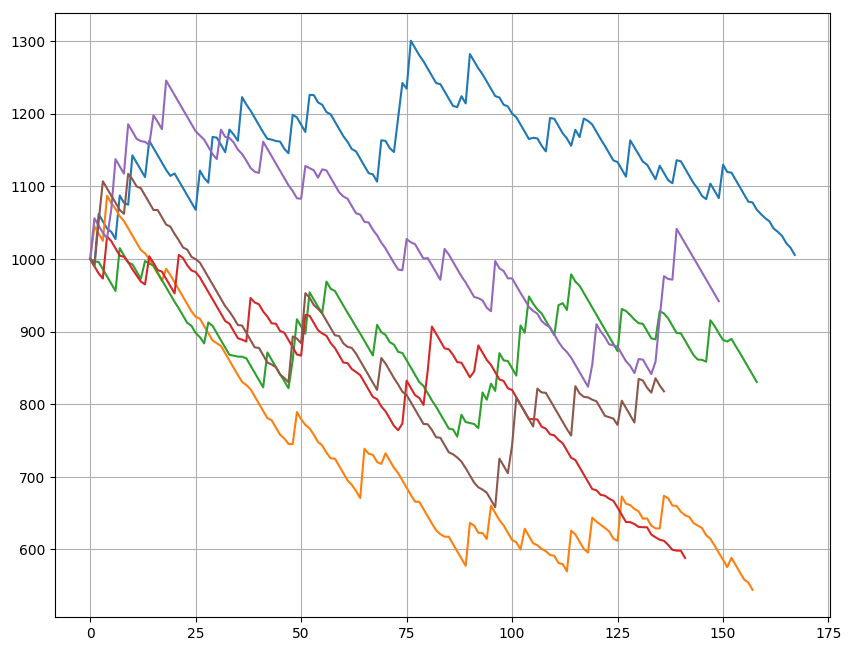

In [19]:
moneys = []
START_MONEY, MAX_BET, MIN_BET = 1000, 10, 0.01
cross_val_folds = 6
for training, testing in getCrossVal(main, cross_val_folds):
    model = LogisticRegression(max_iter=2000)
    X_train = training[FEATURES]
    y_train = training[TARGET]
    X_test = testing[FEATURES]
    y_test = testing[TARGET]
    
    model.fit(X_train, y_train)
    preds = model.predict_proba(X_test)
    
    # Run a betting sim
    data = testing.copy().reset_index(drop=True)
    races = np.unique(data["race_id"])
    money = [float(START_MONEY)]
    betsPlaced = 0.
    betsWon = 0.
    for r in races:
        race = data.loc[data["race_id"]==r]
        raceSize = race.shape[0]
        raceI = race.index
    
        modelPreds = np.array([i for _, i in preds[raceI]])
        modelPreds = [i/sum(modelPreds) for i in modelPreds]
        
        actOdds = data.iloc[raceI]["win_odds"].to_numpy()
        results = data.iloc[raceI]["won"].to_numpy()
        venue = data.iloc[raceI[0]]["venue"]
        pastRaceNum = data.iloc[raceI]["num_of_races"].to_numpy()
        
        # RESTRICTION
        if venue == "ST":
            continue
        
        winnerI = np.argmax(results)
        
        for i in range(raceSize):
            myProb = modelPreds[i]
            decOdds = actOdds[i]
            
            # RESTRICTION
            #if decOdds >= 8 or decOdds <= 4:
            #if decOdds > 1.0:
            if decOdds >= 5.0 and decOdds <= 8.0:
                pass
            else:
                continue
            advantage = myProb*decOdds - 1. 
            K = advantage / (decOdds - 1.)
            if K <= 0:
                continue
            recBet = money[-1] * K
            
            if recBet > MIN_BET: # Means we are gonna bet
                betsPlaced += 1
                didWin = (winnerI == i)
                recBet *= 0.7
                
                actualBet = recBet if recBet < MAX_BET else MAX_BET
                    
                if didWin:
                    betsWon += 1
                    newMoney = money[-1] + actualBet * (decOdds - 1)
                else:
                    newMoney = money[-1] - actualBet
                    
                money.append(newMoney)
                
    moneys.append(money)
    print(betsPlaced)
    
plt.figure(figsize=(10,8), dpi=100)
for m in moneys:
    plt.plot(m)
plt.grid()

ROI = sum([moneys[i][-1] for i in range(len(moneys))])/len(moneys)
print("ROI: {}".format(ROI))